<a href="https://colab.research.google.com/github/Sestiano/Semantic-Analysis-of-Texts-Generated-with-Mistral-AI/blob/main/Hakan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Analysis of Texts Generated with Mistral AI

This notebook contains the analysis of texts generated using the Mistral AI model with different temperatures and prompts. The objective is to study how the characteristics of semantic networks change as the generation temperature and prompt type (complex vs vague) vary.

Fundamental principles of the analysis:
- Generation of texts with controlled parameters
- Creation of semantic networks using two approaches: co-occurrence and EmoAtlas
- Metric analysis of the generated semantic networks
- Visualization of results and comparative analysis

## Text Generation with Mistral AI

Configuration of parameters for text generation using the Mistral API. Texts will be generated using different temperatures and two types of prompts (complex and vague).

In [ ]:
!pip install mistralai # Comment this line if you are not running on Google Colab

In [3]:
from mistralai import Mistral
import os

In [11]:
# ================== CONFIGURATION ==================

API_KEY = "PLEASE_ADD_YOUR_API_KEY_HERE"
MODEL = "mistral-small-latest"
TEMPERATURES = [0.001, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

N_COMPLETIONS = 50

SYSTEM_INSTRUCTION = (
    """ Please read the following prompt carefully and adopt the perspective of a writer.
    Your task is to continue the story in any direction you choose.
    The story should be between 250 and 350 words. """
)

PROMPTS = {
    "prompt_complex": (
        """ Cameron opened the door and slid inside, slowly. Her dull, colourless room welcomed
        her, looking back at her pointlessly. She sighed profoundly, throwing her bag in
        the corner. Another slow, painfully slow evening was waiting for her. She took a
        shower, trying to shake a crawling feeling of emptiness away from her body. She
        ate without any pleasure and stared blankly at the tv for some time, and ended up
        falling asleep the second her head touched the pillow. The morning after, she
        opened her eyes, already surrendered to the doom of her everyday life; but to her
        great surprise, she found herself """
    ),
    "prompt_vague": (
        """Cameron, after that very stressful day, fell asleep in her bed as usual.
        The next day she opened her eyes and, to her great surprise, found herself
        """
      # you can add more prompts here
    ),
}

client = Mistral(api_key=API_KEY)

for prompt_name, prompt_text in PROMPTS.items():
  # Folder with prompt name
    out_dir = f"mistral_{prompt_name}"
    os.makedirs(out_dir, exist_ok=True)

    for temp in TEMPERATURES:
        completions = []
        n = N_COMPLETIONS
        while len(completions) < n:
            batch_size = min(10, n - len(completions))

            response = client.chat.complete(
                model=MODEL,
                messages=[
                    {"role": "system", "content": SYSTEM_INSTRUCTION},
                    {"role": "user", "content": prompt_text},
                ],
                temperature=temp,
                n=batch_size,
            )

            # Every choice has response.choices[i].message.content

            batch = [choice.message.content.strip() for choice in response.choices]
            completions.extend(batch)

        # Write n texts on file separated by two lines

        file_path = os.path.join(out_dir, f"{prompt_name}_{temp}.txt")
        with open(file_path, "w", encoding="utf-8") as f:
            f.write("\n\n".join(completions))

        print(f"generated {n} text for {prompt_name} temp={temp} in {file_path}")


generated 50 text for prompt_complex temp=0.001 in mistral_prompt_complex/prompt_complex_0.001.txt
generated 50 text for prompt_complex temp=0.25 in mistral_prompt_complex/prompt_complex_0.25.txt
generated 50 text for prompt_complex temp=0.5 in mistral_prompt_complex/prompt_complex_0.5.txt
generated 50 text for prompt_complex temp=0.75 in mistral_prompt_complex/prompt_complex_0.75.txt
generated 50 text for prompt_complex temp=1.0 in mistral_prompt_complex/prompt_complex_1.0.txt
generated 50 text for prompt_complex temp=1.25 in mistral_prompt_complex/prompt_complex_1.25.txt
generated 50 text for prompt_complex temp=1.5 in mistral_prompt_complex/prompt_complex_1.5.txt
generated 50 text for prompt_vague temp=0.001 in mistral_prompt_vague/prompt_vague_0.001.txt
generated 50 text for prompt_vague temp=0.25 in mistral_prompt_vague/prompt_vague_0.25.txt
generated 50 text for prompt_vague temp=0.5 in mistral_prompt_vague/prompt_vague_0.5.txt
generated 50 text for prompt_vague temp=0.75 in mist

## Cleaning of Generated Texts

The following code is responsible for cleaning the generated texts by removing:
- Punctuation
- Stop words
- Numbers
- Special characters

We use Spacy for advanced linguistic processing, which allows for more sophisticated analysis compared to simple regular expressions.

In [ ]:
!pip install spacy glob2 # Comment this line if you are not running on Google Colab
!python -m spacy download en_core_web_lg # We use en_core_web_lg to clean the text

In [8]:
import spacy
import glob
import string

In [16]:
def clean_and_export_with_spacy(raw_text: str, lang_model: str = 'en_core_web_lg') -> str:
    """
    Cleans a text using Spacy by removing punctuation, stop words, and numbers.

    Args:
        raw_text: the text to clean
        lang_model: the linguistic model to use (default: en_core_web_lg)

    Returns:
        the cleaned text with one line per sentence
    """
    # Normalize newline characters
    raw_text = raw_text.replace("\\n", "\n")

    # Load the linguistic model
    nlp = spacy.load(lang_model)

    # Process the text with Spacy
    doc = nlp(raw_text)

    # Process each sentence separately
    cleaned_lines = []
    for sent in doc.sents:
        # Extract only relevant tokens and remove special characters
        tokens = [
            tok.text.lower().translate(str.maketrans('', '', string.punctuation))
            for tok in sent
            if not tok.is_space      # remove spaces
            and not tok.is_stop      # remove stop words
            and not tok.is_punct     # remove punctuation
            and not tok.like_num     # remove numbers
        ]

        # Join tokens in a line
        line = " ".join(t for t in tokens if t)
        if line:  # add only non-empty lines
            cleaned_lines.append(line)

    # Return the cleaned text
    return "\n".join(cleaned_lines)

if __name__ == '__main__':
    # Find all text files in all directories
    for path in glob.glob('**/*.txt', recursive=True):
        # Skip already cleaned files or those in edge-list directories
        if (path.endswith('_cleaned.txt') or
            os.path.dirname(path).startswith(('emo_edges_', 'edges_'))):
            continue

        # Read the content of the original file
        with open(path, 'r', encoding='utf-8') as f:
            raw = f.read()

        # Apply text cleaning
        cleaned = clean_and_export_with_spacy(raw)

        # Save the cleaned text in a new file with suffix "_cleaned"
        out_path = f"{os.path.splitext(path)[0]}_cleaned.txt"
        with open(out_path, 'w', encoding='utf-8') as f:
            f.write(cleaned)

        print(f'→ file cleaned: {out_path}')

→ file cleaned: mistral_prompt_complex/prompt_complex_1.5_cleaned.txt
→ file cleaned: mistral_prompt_complex/prompt_complex_1.25_cleaned.txt
→ file cleaned: mistral_prompt_complex/prompt_complex_0.001_cleaned.txt
→ file cleaned: mistral_prompt_complex/prompt_complex_0.25_cleaned.txt
→ file cleaned: mistral_prompt_complex/prompt_complex_0.75_cleaned.txt
→ file cleaned: mistral_prompt_complex/prompt_complex_1.0_cleaned.txt
→ file cleaned: mistral_prompt_complex/prompt_complex_0.5_cleaned.txt
→ file cleaned: mistral_prompt_vague/prompt_vague_1.5_cleaned.txt
→ file cleaned: mistral_prompt_vague/prompt_vague_0.25_cleaned.txt
→ file cleaned: mistral_prompt_vague/prompt_vague_0.001_cleaned.txt
→ file cleaned: mistral_prompt_vague/prompt_vague_0.5_cleaned.txt
→ file cleaned: mistral_prompt_vague/prompt_vague_1.25_cleaned.txt
→ file cleaned: mistral_prompt_vague/prompt_vague_0.75_cleaned.txt
→ file cleaned: mistral_prompt_vague/prompt_vague_1.0_cleaned.txt


## Imports for Emotional Network Analysis

In this section, we import specific libraries for emotional network analysis, in particular:
- `nltk` for natural language processing
- `emoatlas` for building emotional semantic networks
- `pathlib` for managing file paths in a more modern way

In [ ]:
!pip install nltk # Comment this line if you are not running on Google Colab
!pip install git+https://github.com/MassimoStel/emoatlas # Comment this line if you are not running on Google Colab

In [20]:
import nltk
from emoatlas import EmoScores
import emoatlas as emos
from pathlib import Path

## Creation of Emotional Networks with EmoAtlas

In this section we use the EmoAtlas library to build emotional semantic networks from the generated texts. Unlike the co-occurrence approach, EmoAtlas creates connections based on emotional relationships between words.

The process includes:
1. Loading raw texts (not cleaned)
2. Building a FormaMentis network for each text
3. Exporting edge lists into separate files

In [21]:
# Creation of edge lists with EmoAtlas (from original texts)

nltk.download('wordnet')

emos = EmoScores()

dirs = [
    'mistral_prompt_complex',  # directory with texts generated with complex prompt
    'mistral_prompt_vague',    # directory with texts generated with vague prompt
]

for in_dir in dirs:
    # Extract the prompt type: 'complex' or 'vague'
    prompt_type = in_dir.split('_')[-1]
    # Create the output directory for emotional edge lists
    out_dir = f'emo_edges_{prompt_type}'
    os.makedirs(out_dir, exist_ok=True)

    # Process each original text file (exclude those already cleaned)
    pattern = os.path.join(in_dir, '*.txt')
    for path in glob.glob(pattern):
        filename = os.path.basename(path)
        # Skip already cleaned files
        if filename.endswith('_cleaned.txt'):
            continue

        # Extract the temperature value from the filename: prompt_[type]_[temperature].txt
        base = os.path.splitext(filename)[0]
        parts = base.split('_')
        if len(parts) >= 2:
            temp = parts[-1]  # the last part is the temperature value
        else:
            print(f"Skip {filename}: unable to extract temperature")
            continue

        # Read the original text
        try:
            with open(path, 'r', encoding='utf-8') as f:
                text = f.read()

            print(f"Processing {filename} ({len(text)} bytes)...")

            # Building the emotional network using EmoAtlas
            try:
                # FormaMentis creates a semantic network based on emotional relationships
                network = emos.formamentis_network(text)

                # Verify that the network actually contains edges
                if not hasattr(network, 'edges') or not network.edges:
                    print(f"Warning: No edges created for {filename}")
                    continue

                # Export the edge list
                out_path = os.path.join(out_dir, f'emo_edge_list_{prompt_type}_{temp}.txt')
                with open(out_path, 'w', encoding='utf-8') as outf:
                    for u, v in network.edges:
                        outf.write(f"{u}\t{v}\n")

                print(f"Written {len(network.edges)} edges for {filename} → {out_path}")

            except Exception as e:
                print(f"Error in network generation for {filename}: {str(e)}")

        except Exception as e:
            print(f"Error in reading {path}: {str(e)}")

[nltk_data] Downloading package wordnet to /root/nltk_data...


Processing prompt_complex_1.5.txt (79143 bytes)...
Written 11588 edges for prompt_complex_1.5.txt → emo_edges_complex/emo_edge_list_complex_1.5.txt
Processing prompt_complex_1.25.txt (78132 bytes)...
Written 10967 edges for prompt_complex_1.25.txt → emo_edges_complex/emo_edge_list_complex_1.25.txt
Processing prompt_complex_0.001.txt (81187 bytes)...
Written 6641 edges for prompt_complex_0.001.txt → emo_edges_complex/emo_edge_list_complex_0.001.txt
Processing prompt_complex_0.25.txt (79893 bytes)...
Written 8754 edges for prompt_complex_0.25.txt → emo_edges_complex/emo_edge_list_complex_0.25.txt
Processing prompt_complex_0.75.txt (80732 bytes)...
Written 10438 edges for prompt_complex_0.75.txt → emo_edges_complex/emo_edge_list_complex_0.75.txt
Processing prompt_complex_1.0.txt (79351 bytes)...
Written 9824 edges for prompt_complex_1.0.txt → emo_edges_complex/emo_edge_list_complex_1.0.txt
Processing prompt_complex_0.5.txt (78853 bytes)...
Written 9232 edges for prompt_complex_0.5.txt → e

## Creation of Co-occurrence Graphs

This code is responsible for creating semantic networks based on word co-occurrence in texts. Given a cleaned text, it creates a graph where:
- Nodes are words
- Edges connect words that appear close to each other in the text (within a specified "window")

Output files will be saved in separate folders by prompt type.

In [23]:
import networkx as nx

In [24]:
def load_semantic_network(file_path):
    """
    Loads a semantic network from a text file containing pairs of words.

    Args:
        file_path: path to the file with edges (format: word1\tword2)

    Returns:
        undirected networkx graph
    """
    G = nx.Graph()
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            # Skip empty lines or incorrectly formatted ones
            if not line or '\t' not in line:
                continue
            word1, word2 = line.split('\t')
            G.add_edge(word1, word2)
    return G

In [25]:
def create_edge_list(tokens, window_size=2):
    """
    Creates an edge list based on the co-occurrence of tokens in a sliding window.

    Args:
        tokens: list of tokens (words)
        window_size: size of the co-occurrence window

    Returns:
        list of tuples (token1, token2) representing the edges
    """
    edges = []
    for i in range(len(tokens)):
        # For each token, create edges with subsequent tokens in the window
        for j in range(i+1, min(i + window_size + 1, len(tokens))):
            if tokens[i] != tokens[j]:  # Avoid self-loops
                edges.append((tokens[i], tokens[j]))
    return edges

def process_file(file_path, output_dir, window_size=2):
    """
    Processes a text file to create a co-occurrence network.

    Args:
        file_path: path to the input file
        output_dir: base output directory
        window_size: window size for co-occurrence

    Returns:
        tuple (output file path, number of edges)
    """
    # Reading the text file
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    # Extracting tokens
    tokens = []
    for line in text.splitlines():
        if line.strip():
            tokens.extend(line.split())

    # Creating co-occurrence edges
    edges = create_edge_list(tokens, window_size)

    # Determining output directory based on prompt type
    base = os.path.basename(file_path)
    name, _ = os.path.splitext(base)
    name = name.replace("_cleaned", "")

    actual_output_dir = output_dir
    if "prompt_complex" in name:
        actual_output_dir = "edges_complex"
    elif "prompt_vague" in name:
        actual_output_dir = "edges_vague"

    os.makedirs(actual_output_dir, exist_ok=True)
    out_path = os.path.join(actual_output_dir, f"edge_list_{name}.txt")

    # Writing the edge list
    with open(out_path, "w", encoding="utf-8") as out:
        for src, tgt in edges:
            out.write(f"{src} {tgt}\n")

    return out_path, len(edges)

def main():
    window_size = int(input("Enter window size (default=2): ") or "2")

    os.makedirs("edges_complex", exist_ok=True)
    os.makedirs("edges_vague", exist_ok=True)

    complex_cleaned_pattern = "**/*prompt_complex_*_cleaned.txt"
    vague_cleaned_pattern = "**/*prompt_vague_*_cleaned.txt"

    complex_files = glob.glob(complex_cleaned_pattern, recursive=True)
    vague_files = glob.glob(vague_cleaned_pattern, recursive=True)

    if not complex_files and not vague_files:
        print("No _cleaned.txt files found. Make sure you've run the cleaning script first.")
        return

    print(f"Found {len(complex_files)} 'complex_cleaned' files and {len(vague_files)} 'vague_cleaned' files.")

    results = []

    all_files = complex_files + vague_files

    if not all_files:
        print("No _cleaned.txt files found. Make sure you've run the cleaning script first.")
        return

    print(f"Found {len(all_files)} cleaned files to process.")

    for fp in all_files:
        if "prompt_complex" in fp:
            output_dir = "edges_complex"
        elif "prompt_vague" in fp:
            output_dir = "edges_vague"
        else:
            output_dir = "edges_other"

        out, count = process_file(fp, output_dir=output_dir, window_size=window_size)
        results.append((fp, out, count))

    print("\nSummary:")
    for inp, outp, cnt in results:
        print(f"{inp} → {outp}: {cnt} edges")

if __name__ == "__main__":
    main()

Enter window size (default=2): 2
Found 7 'complex_cleaned' files and 7 'vague_cleaned' files.
Found 14 cleaned files to process.

Summary:
mistral_prompt_complex/prompt_complex_1.25_cleaned.txt → edges_complex/edge_list_prompt_complex_1.25.txt: 13190 edges
mistral_prompt_complex/prompt_complex_1.0_cleaned.txt → edges_complex/edge_list_prompt_complex_1.0.txt: 13307 edges
mistral_prompt_complex/prompt_complex_0.75_cleaned.txt → edges_complex/edge_list_prompt_complex_0.75.txt: 13440 edges
mistral_prompt_complex/prompt_complex_0.25_cleaned.txt → edges_complex/edge_list_prompt_complex_0.25.txt: 13495 edges
mistral_prompt_complex/prompt_complex_0.001_cleaned.txt → edges_complex/edge_list_prompt_complex_0.001.txt: 13679 edges
mistral_prompt_complex/prompt_complex_1.5_cleaned.txt → edges_complex/edge_list_prompt_complex_1.5.txt: 13317 edges
mistral_prompt_complex/prompt_complex_0.5_cleaned.txt → edges_complex/edge_list_prompt_complex_0.5.txt: 13105 edges
mistral_prompt_vague/prompt_vague_1.0_c

## Semantic Network Analysis

In this section, we analyze the generated semantic networks, calculating important metrics such as:
- Number of nodes and edges
- Network density
- Clustering coefficient
- Average path length
- Average and maximum node degree

The results will be visualized in graphs and saved in a CSV file for subsequent analysis.

In [26]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import re
import numpy as np

def extract_temperature(id_string):
    """Extracts the temperature value from the file name."""
    match = re.search(r'_(\d+(?:\.\d+)?)(?:_cleaned)?', id_string)
    return float(match.group(1)) if match else None

In [27]:
# Edge-list Analysis

def analyze_edge_list(file_path):
    """
    Analyzes an edge-list file and calculates the network metrics.

    Args:
        file_path: path to the file containing the edge list

    Returns:
        dictionary with the calculated metrics or None in case of error
    """
    try:
        # Loading edges and building the graph in a single pass
        G = nx.Graph()
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    G.add_edge(parts[0], parts[1])

        # Calculating network metrics
        n = G.number_of_nodes()
        m = G.number_of_edges()

        # Safe calculation of metrics (handling edge cases)
        density = (2 * m) / (n * (n - 1)) if n > 1 else 0
        avg_clustering = nx.average_clustering(G) if n > 0 else 0

        # Calculating average path length (only if graph is connected)
        path_len = float('nan')  # default value
        if nx.is_connected(G) and n > 1:
            try:
                path_len = nx.average_shortest_path_length(G)
            except:
                pass  # keeps NaN value

        # Calculation of degree-based metrics
        degrees = [d for _, d in G.degree()]
        avg_degree = sum(degrees) / n if n > 0 else 0
        max_degree = max(degrees) if degrees else 0

        # Automatic determination of method and prompt type
        lower = file_path.lower()
        method = ('emoatlas' if 'emo_edges_' in lower else
                 'cooccurrence' if 'edges_' in lower else 'other')
        prompt_type = ('complex' if 'complex' in lower else
                      'vague' if 'vague' in lower else 'other')

        file_name = os.path.splitext(os.path.basename(file_path))[0]

        # Creation of the results dictionary
        return {
            'id': file_name,
            'method': method,
            'prompt_type': prompt_type,
            'nodes': n,
            'edges': m,
            'density': density,
            'clustering': avg_clustering,
            'path_len': path_len,
            'avg_deg': avg_degree,
            'max_deg': max_degree,
            'file_path': file_path
        }

    except Exception as e:
        print(f"Error analyzing {file_path}: {e}")
        return None

# Visualizations

def create_visualizations(df):
    """
    Creates and saves visualizations for each method and prompt type.

    Args:
        df: DataFrame with network metrics data

    Returns:
        str: path to the output directory
    """
    # Create the directory for visualizations
    out_dir = Path('visualizations')
    out_dir.mkdir(exist_ok=True)

    # Helper function to extract temperature from ID
    def extract_temperature(id_str):
        m = re.search(r'[_-](\d+(?:\.\d+)?)$', id_str)
        return m.group(1) if m else 'N/A'

    # Iterate over methods and prompt types
    for method in df['method'].unique():
        for prompt_type in ['complex', 'vague']:
            sub = df[(df['method'] == method) & (df['prompt_type'] == prompt_type)]
            if sub.empty:
                continue

            # 1. Scatter plot of Nodes vs Edges
            plt.figure(figsize=(10, 6))
            # Point size proportional to density
            plt.scatter(sub['nodes'], sub['edges'], s=sub['density'] * 5000, alpha=0.7)
            # Add temperature labels
            for _, row in sub.iterrows():
                temp = extract_temperature(row['id'])
                plt.annotate(temp, (row['nodes'], row['edges']), fontsize=8)
            # Title and axes
            plt.xlabel('Nodes')
            plt.ylabel('Edges')
            plt.title(f'Nodes vs Edges ({method} - {prompt_type})')
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.savefig(out_dir / f'nodes_edges_{method}_{prompt_type}.png', dpi=300)
            plt.close()

            # 2. Bar charts for density and clustering
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            density_df = sub.sort_values('density', ascending=False)
            temps = [extract_temperature(i) for i in density_df['id']]

            # Density chart
            ax[0].bar(temps, density_df['density'], alpha=0.7)
            ax[0].set_title(f'Density ({method} - {prompt_type})')
            ax[0].set_ylabel('Density')
            ax[0].tick_params(axis='x', rotation=45)

            # Clustering chart
            ax[1].bar(temps, density_df['clustering'], alpha=0.7)
            ax[1].set_title(f'Clustering ({method} - {prompt_type})')
            ax[1].set_ylabel('Clustering Coefficient')
            ax[1].tick_params(axis='x', rotation=45)

            fig.tight_layout()
            plt.savefig(out_dir / f'density_clustering_{method}_{prompt_type}.png', dpi=300)
            plt.close()

    return str(out_dir)

# -------------------------------------------------------------
# MAIN
# -------------------------------------------------------------

def main():
    """
    Main function for network metrics analysis.

    Performs the following operations:
    1. Collection of all edge-list files
    2. Analysis of metrics for each network
    3. Creation of summary tables
    4. Generation of visualizations
    5. Calculation of comparative statistics
    """
    print('=== NETWORK METRICS ANALYSIS ===')

    # Collection of edge-list files from all directories
    edge_dirs = ['emo_edges_complex', 'emo_edges_vague', 'edges_complex', 'edges_vague']
    files = []
    for d in edge_dirs:
        if Path(d).is_dir():
            found = glob.glob(os.path.join(d, '*edge_list_*.txt'))
            print(f"Found {len(found)} files in {d}")
            files.extend(found)

    if not files:
        print('No edge-list files found.')
        return

    # Analysis of each file
    results = []
    for fp in files:
        print(f'Analyzing {os.path.basename(fp)}')
        metrics = analyze_edge_list(fp)
        if metrics:
            results.append(metrics)

    if not results:
        print('No results to display.')
        return

    # Creating DataFrame with results
    df = pd.DataFrame(results)

    # Saving metrics to CSV
    Path('results').mkdir(exist_ok=True)
    csv_path = Path('results/network_metrics.csv')
    df.to_csv(csv_path, index=False)
    print(f'Metrics saved to {csv_path}')

    # Summary tables by prompt type
    for pt in ['complex', 'vague']:
        sub = df[df['prompt_type'] == pt]
        if sub.empty:
            continue
        print(f"\nSUMMARY ({pt}):")
        print(tabulate(sub[['id','nodes','edges','density','avg_deg']],
                       headers=['ID','Nodes','Edges','Density','AvgDegree'],
                       tablefmt='grid'))

    # Creating visualizations
    viz_dir = create_visualizations(df)
    print(f'Visualizations saved to {viz_dir}')

    # Comparative stats
    if set(df['prompt_type']) >= {'complex','vague'}:
        cols = ['nodes','edges','density','avg_deg','clustering']
        comp = df[df['prompt_type']=='complex'][cols].mean()
        vag = df[df['prompt_type']=='vague'][cols].mean()
        diff = ((vag - comp) / comp.replace(0, np.nan) * 100).round(2)
        table = [[c, f"{comp[c]:.2f}", f"{vag[c]:.2f}", f"{diff[c]:+.2f}%"] for c in cols]
        print("\nCOMPARISON COMPLEX vs VAGUE:")
        print(tabulate(table, headers=['Metric','Complex','Vague','Δ%'], tablefmt='grid'))

    print('\nAnalysis complete.')

if __name__ == '__main__':
    main()


=== NETWORK METRICS ANALYSIS ===
Found 7 files in emo_edges_complex
Found 7 files in emo_edges_vague
Found 7 files in edges_complex
Found 7 files in edges_vague
Analyzing emo_edge_list_complex_1.25.txt
Analyzing emo_edge_list_complex_0.001.txt
Analyzing emo_edge_list_complex_0.5.txt
Analyzing emo_edge_list_complex_0.75.txt
Analyzing emo_edge_list_complex_1.0.txt
Analyzing emo_edge_list_complex_0.25.txt
Analyzing emo_edge_list_complex_1.5.txt
Analyzing emo_edge_list_vague_1.5.txt
Analyzing emo_edge_list_vague_1.0.txt
Analyzing emo_edge_list_vague_0.75.txt
Analyzing emo_edge_list_vague_1.25.txt
Analyzing emo_edge_list_vague_0.25.txt
Analyzing emo_edge_list_vague_0.5.txt
Analyzing emo_edge_list_vague_0.001.txt
Analyzing edge_list_prompt_complex_0.001.txt
Analyzing edge_list_prompt_complex_1.25.txt
Analyzing edge_list_prompt_complex_1.0.txt
Analyzing edge_list_prompt_complex_0.25.txt
Analyzing edge_list_prompt_complex_0.75.txt
Analyzing edge_list_prompt_complex_0.5.txt
Analyzing edge_list_

## Advanced Statistical Analysis of Semantic Networks

This section implements advanced statistical analysis of semantic network metrics, with particular attention to:

1. Descriptive statistics by method and prompt type
2. Correlations between different metrics (heatmap)
3. Visualization of relationships between pairs of metrics
4. Density and clustering charts as temperature varies
5. Two-way ANOVA (Prompt × Temperature)
6. Residual normality tests
7. Spearman correlations between temperature and metrics

The results offer an in-depth view of the impact of temperature and prompt type on the characteristics of semantic networks.

In [28]:
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

In [29]:
# Configuration for statistical analysis of semantic networks
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style("whitegrid")

# Configurable parameters for analysis
CSV_PATH = Path("results/network_metrics.csv")  # relative to project root
SAVE_FIGS = True                                # set False to skip PNG output
FIG_DIR = Path("figures")                      # where PNGs will be stored
FIG_DIR.mkdir(exist_ok=True)

# 1. Data loading and preparation
print("\n[ Phase 1 ]  Loading data ...")
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV file not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# Derive method: EmoAtlas vs co-occurrence
if 'file_path' not in df.columns:
    raise ValueError("Column 'file_path' not found in CSV.")
df['method'] = df['file_path'].apply(
    lambda x: 'emoatlas' if 'emo_edges_' in x.lower()
              else 'cooccurrence' if 'edges_' in x.lower()
              else 'other'
)
df['method'] = df['method'].astype('category')

# Ensure prompt_type is categorical
if 'prompt_type' not in df.columns:
    raise ValueError("Column 'prompt_type' not found in CSV.")
df['prompt_type'] = df['prompt_type'].astype('category')

# Extract / coerce temperature to float
if 'temperature' not in df.columns or df['temperature'].isna().all():
    def _get_temp(s: str):
        m = re.search(r"_(\d+(?:\.\d+)?)$", s)
        return float(m.group(1)) if m else np.nan
    df['temperature'] = df['id'].apply(_get_temp)
df['temperature'] = df['temperature'].astype(float)

print(df.head())

# 2. Descriptive statistics
print("\n[ Phase 2 ]  Descriptive statistics by method and prompt type ...")
metrics = ['nodes', 'edges', 'density', 'clustering', 'avg_deg', 'path_len']
desc = df.groupby(['method', 'prompt_type'])[metrics].agg(['mean', 'std'])
print(desc.round(3))

# 3. Correlation heatmaps by method
for method in df['method'].cat.categories:
    sub = df[df['method'] == method]
    if sub.empty:
        continue
    # Calculate Spearman correlations
    corr = sub[metrics].corr(method='spearman')
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag')
    plt.title(f"Spearman Correlations ({method})")
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(FIG_DIR / f"metric_correlations_{method}.png", dpi=300)
    plt.close()

# 3.5 Relationships between pairs of metrics by method
for method in df['method'].cat.categories:
    sub = df[df['method'] == method]
    if sub.empty:
        continue
    # Creating the plot of relationships between pairs of metrics
    g = sns.pairplot(
        sub,
        vars=metrics,
        hue='prompt_type',  # Coloring by prompt type
        diag_kind='kde',    # Kernel density on diagonal
        corner=True,        # Only half of the plot to avoid duplicates
        plot_kws={'alpha':0.7}
    )
    g.fig.suptitle(f"Relationships between pairs of metrics ({method})", y=1.02)
    if SAVE_FIGS:
        g.savefig(FIG_DIR / f"pairwise_{method}.png", dpi=300)
    plt.close()

# 4. Bar charts for density and clustering by method and prompt type
for method in df['method'].cat.categories:
    for prompt in df['prompt_type'].cat.categories:
        # Filter dataset by method and prompt type
        sub = df[(df['method'] == method) & (df['prompt_type'] == prompt)]
        if sub.empty:
            continue

        # Sort by temperature to visualize the effect of increasing temperature
        sub = sub.sort_values('temperature')
        temps = sub['temperature'].astype(str)

        # Create a plot with two side-by-side panels
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Create indices for bars
        x = np.arange(len(temps))

        # Plot for density
        axes[0].bar(x, sub['density'], alpha=0.7, color='steelblue')
        axes[0].set_title(f"Density ({prompt}) - {method}")
        axes[0].set_ylabel('Density')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(temps, rotation=45)
        axes[0].grid(axis='y', linestyle='--', alpha=0.3)

        # Plot for clustering coefficient
        axes[1].bar(x, sub['clustering'], alpha=0.7, color='forestgreen')
        axes[1].set_title(f"Clustering Coefficient ({prompt}) - {method}")
        axes[1].set_ylabel('Clustering Coefficient')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(temps, rotation=45)
        axes[1].grid(axis='y', linestyle='--', alpha=0.3)

        fig.tight_layout()
        if SAVE_FIGS:
            fig.savefig(FIG_DIR / f"density_clustering_{method}_{prompt}.png", dpi=300)
        plt.close(fig)

# 5. Scatter plots with regression lines: metrics as a function of temperature
for metric in metrics:
    # Create a plot with linear regression using seaborn
    grid = sns.lmplot(
        data=df,
        x='temperature', y=metric,         # temperature on x-axis, metric on y-axis
        hue='prompt_type',                 # different colors for prompt type
        col='method',                      # separate columns for method
        scatter_kws={'s': 50, 'alpha': 0.8}, # size and transparency of points
        height=4, aspect=1.2,              # size of each panel
        facet_kws={'sharex': True, 'sharey': False}  # same x scale, independent y scale
    )

    # Add a global title
    grid.fig.suptitle(f"{metric} as a function of temperature by prompt and method", y=1.02)

    # Save the plot if requested
    if SAVE_FIGS:
        grid.savefig(FIG_DIR / f"{metric}_by_temp_method.png", dpi=300)
    plt.close()

# 6. Two-way ANOVA (Prompt × Temperature) for each method
print("\n[ Phase 3 ]  Two-way ANOVA (temperature as a numerical variable) by method ...")
for method in df['method'].cat.categories:
    sub = df[df['method'] == method]
    if sub.empty:
        continue
    print(f"\n-- METHOD: {method} --")
    # ANOVA analysis for each metric
    for metric in metrics:
        # Model that considers the effect of prompt type, temperature, and their interaction
        model = ols(f"{metric} ~ C(prompt_type) * temperature", data=sub).fit()
        # Type 2 ANOVA (test for main effects controlling for other factors)
        anova_tbl = sm.stats.anova_lm(model, typ=2)
        print(f"\n— {metric.upper()} —")
        print(anova_tbl.round(4))

# 7. Checking for normality of residuals (Shapiro-Wilk test) by method
print("\n[ Phase 4 ]  P-values for residual normality test (Shapiro-Wilk) by method ...")
for method in df['method'].cat.categories:
    sub = df[df['method'] == method]
    if sub.empty:
        continue
    print(f"\n-- METHOD: {method} --")
    # Test for each metric
    for metric in metrics:
        # Calculate residuals from the model
        res = ols(f"{metric} ~ C(prompt_type) * temperature", data=sub).fit().resid
        # Shapiro-Wilk test for normality
        W, p = stats.shapiro(res)
        # P-values < 0.05 indicate deviation from normality
        print(f"{metric:12}: p = {p:.3f}")

# 8. Spearman correlations between temperature and metrics by prompt and method
print("\n[ Phase 5 ]  Spearman's ρ correlation coefficients between temperature and metrics ...")
for method in df['method'].cat.categories:
    sub_m = df[df['method'] == method]
    if sub_m.empty:
        continue
    print(f"\n-- METHOD: {method} --")
    # Analysis for each prompt type
    for prompt in sub_m['prompt_type'].cat.categories:
        sub = sub_m[sub_m['prompt_type'] == prompt]
        if sub.empty:
            continue
        print(f" Prompt = {prompt}")
        # Calculate correlations for each metric
        for metric in metrics:
            # Spearman correlation (non-parametric, resistant to outliers)
            rho, p = stats.spearmanr(sub['temperature'], sub[metric])
            # Show coefficient with sign and p-value
            print(f"  {metric:12}: ρ = {rho:+.3f},  p = {p:.03f}")

print("\nAnalysis completed.")


[ Phase 1 ]  Loading data ...
                            id    method prompt_type  nodes  edges   density  \
0   emo_edge_list_complex_1.25  emoatlas     complex   1097  10967  0.018243   
1  emo_edge_list_complex_0.001  emoatlas     complex    802   6641  0.020676   
2    emo_edge_list_complex_0.5  emoatlas     complex    967   9232  0.019766   
3   emo_edge_list_complex_0.75  emoatlas     complex   1028  10438  0.019774   
4    emo_edge_list_complex_1.0  emoatlas     complex   1010   9822  0.019276   

   clustering  path_len    avg_deg  max_deg  \
0    0.499671       NaN  19.994531      545   
1    0.509518  2.590325  16.561097      381   
2    0.503280  2.555013  19.094105      489   
3    0.509987  2.536721  20.307393      523   
4    0.492156  2.575767  19.449505      490   

                                           file_path  temperature  
0   emo_edges_complex/emo_edge_list_complex_1.25.txt        1.250  
1  emo_edges_complex/emo_edge_list_complex_0.001.txt        0.001  
2

## Visualization and Analysis of Word Neighborhoods

This section implements functionality to visualize neighborhoods of specific words within semantic networks. It is possible to:

1. Visualize the neighborhood of a single word in a specific network
2. Compare the neighborhoods of a word across multiple networks simultaneously

Configurable parameters:
- Central word
- Neighborhood radius (maximum distance from the central word)
- Layout algorithm (spring, circular, kamada_kawai, spectral)
- k parameter for spring layout (influences the distance between nodes)

Results can be saved in PDF format for subsequent analysis or presentations.

We use a sample configuration with EmoAtlas but you can change as you want when you run the code


=== SEMANTIC NETWORK ANALYSIS ===

Select network type: "emo" (EmoAtlas) or "cooc" (co-occurrence): emo

Loading graphs from directories: ['emo_edges_complex', 'emo_edges_vague']

Words common to all graphs: she, her, it, cameron, look, fill, you, find, eye, feel, small, room, open, I, walk

Options:
 1) View single neighborhood  2) Compare multiple neighborhoods  3) Exit
Choice: 2
Word to compare: mind
Radius (default 1): 1
Layout [spring, circular, kamada_kawai, spectral] (default spring): kamada_kawai
k (0.3-1.5, default 0.5): 
Save PDF? (y/N): N


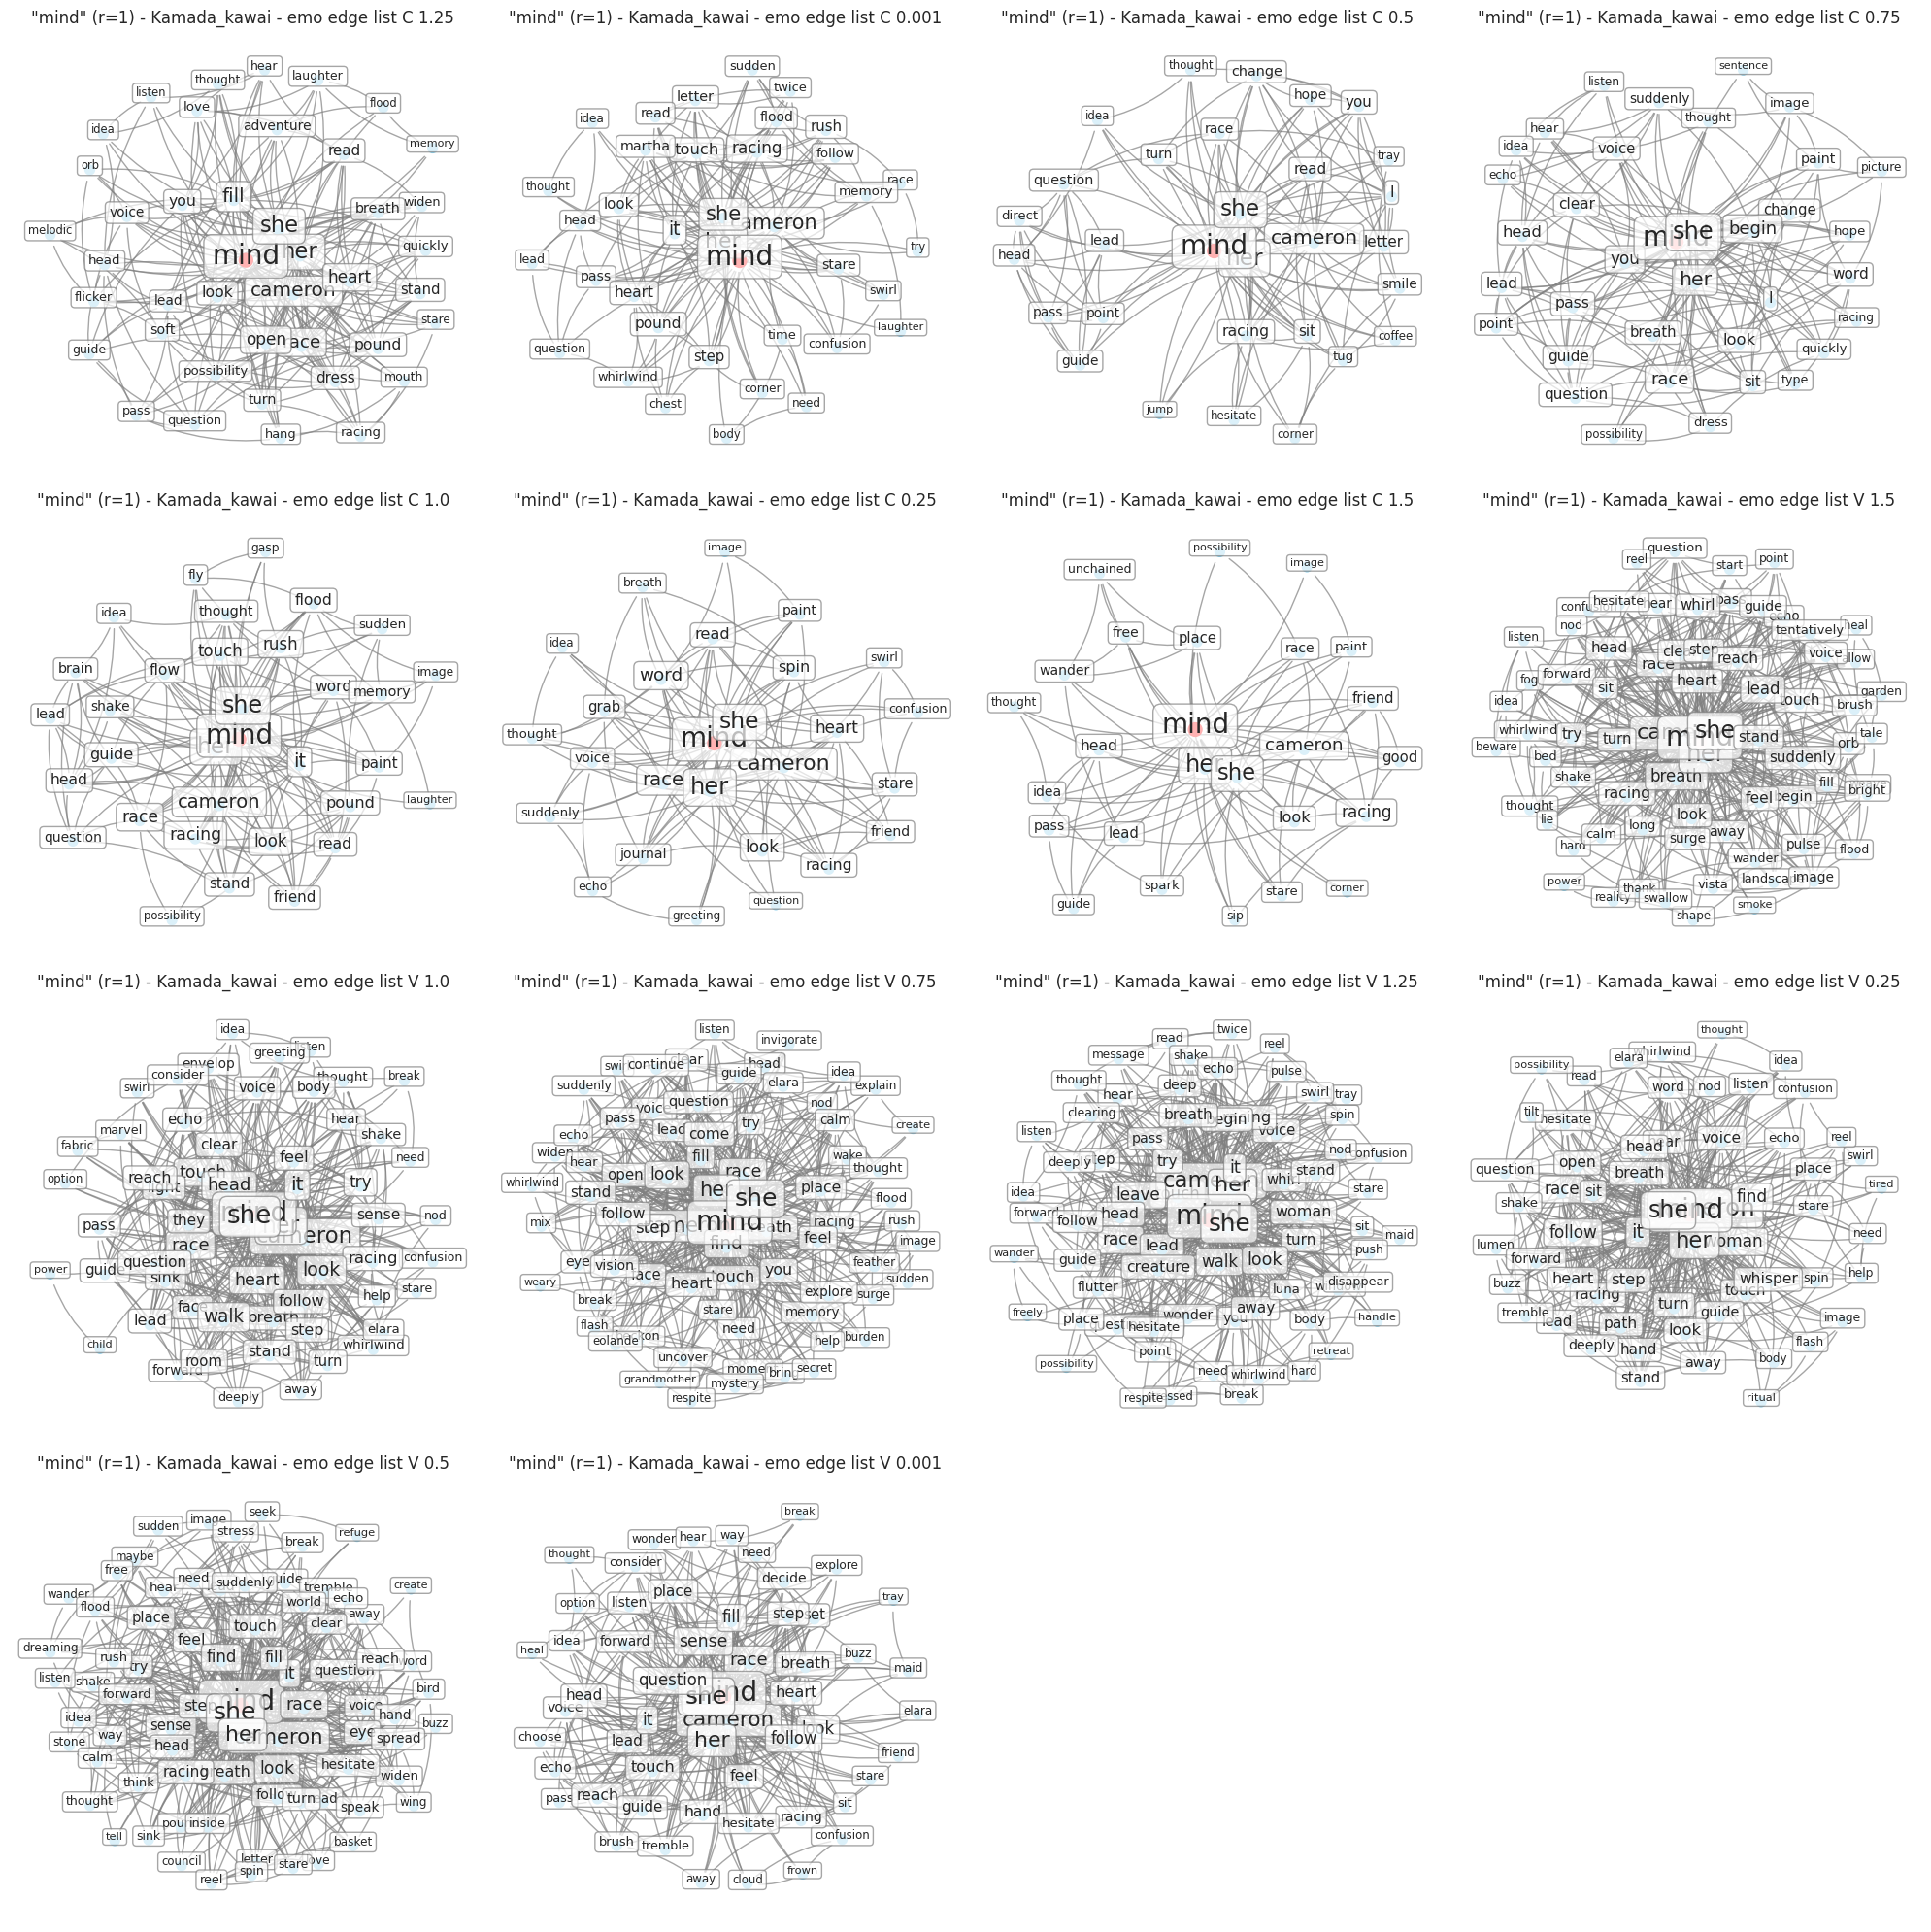

In [32]:
# Configuration for semantic neighborhood visualization
warnings_import = False
try:
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings_import = True
except:
    pass
sns.set_style("whitegrid")

# Utility functions for visualization

def short_name(raw: str) -> str:
    """Returns a compact name for the graph."""
    name = re.sub(r'^(edge_|edge_list_|edges_|edge-list_|edges-list_)?', '', raw)
    name = name.replace('prompt_', '')
    name = name.replace('complex', 'C').replace('vague', 'V')
    return re.sub(r'_+', ' ', name).strip()


def load_graph_from_edge_list(file_path: str) -> nx.Graph:
    """Loads an undirected graph from a file containing an edge list."""
    G = nx.Graph()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                G.add_edge(parts[0], parts[1])
    return G


def visualize_neighborhood(G: nx.Graph, word: str, radius: int = 1,
                           layout: str = 'spring', ax=None,
                           title_suffix: str = '',
                           min_font: int = 8, max_font: int = 20,
                           k: float = 0.5) -> bool:
    """
    Draws the ego graph around `word` with specified radius and layout.

    Args:
        G: Networkx graph
        word: Central word
        radius: Maximum radius (distance) from central node
        layout: Layout type ('spring', 'circular', 'kamada_kawai', 'spectral')
        ax: Matplotlib Axes (if None, creates a new one)
        title_suffix: Suffix to add to the title
        min_font: Minimum font size
        max_font: Maximum font size
        k: Distance parameter for spring layout

    Returns:
        bool: True if the graph was drawn, False if the word is not in the graph
    """
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()

    if word not in G:
        ax.text(0.5, 0.5, f'Word "{word}" not found.', ha='center', va='center')
        ax.axis('off')
        return False

    # Extract the ego subgraph around the target word
    sub = nx.ego_graph(G, word, radius=radius)

    # Select and apply the appropriate layout
    layout_funcs = {
        'spring': lambda g: nx.spring_layout(g, seed=42, k=k),
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'spectral': nx.spectral_layout
    }
    pos = layout_funcs.get(layout, nx.spring_layout)(sub)

    # Add some jitter to positions to avoid overlaps
    pos = {n: (x + np.random.normal(0, .02), y + np.random.normal(0, .02))
           for n, (x, y) in pos.items()}

    # Draw edges with arc style to avoid overlaps
    nx.draw_networkx_edges(sub, pos, ax=ax,
                           connectionstyle='arc3,rad=0.15', alpha=0.7,
                           edge_color='gray', arrows=True)

    # Draw nodes with target node in red
    nx.draw_networkx_nodes(sub, pos, ax=ax,
                           node_color=['red' if n == word else 'skyblue' for n in sub],
                           node_size=[100 if n == word else 50 for n in sub])

    # Calculate font size based on centrality
    centrality = nx.degree_centrality(sub)
    min_c, max_c = min(centrality.values()), max(centrality.values())
    fonts = {
        n: max_font if n == word else
           min_font + (max_font-min_font)*(centrality[n]-min_c)/(max_c-min_c or 1)
        for n in sub
    }

    # Add labels with background box
    bbox = dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.7)
    for n, (x, y) in pos.items():
        ax.text(x, y+0.02, n, fontsize=fonts[n], ha='center', va='center', bbox=bbox)

    title = f'"{word}" (r={radius}) - {layout.capitalize()} - {short_name(title_suffix)}'
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    return True


def get_common_words(graphs: dict, top_n: int = 15) -> list:
    """
    Returns the top_n words common to all graphs, ordered by average degree.
    Args:
        graphs: {name: {'graph': nx.Graph}}
        top_n: maximum number of words to return
    """
    if not graphs:
        return []
    # Find intersection between all node sets
    node_sets = [set(data['graph'].nodes()) for data in graphs.values()]
    common = set.intersection(*node_sets) if node_sets else set()
    if not common:
        return []

    # Calculate score (average degree) for each word
    scores = {}
    for w in common:
        total = sum(data['graph'].degree(w) for data in graphs.values())
        scores[w] = total / len(graphs)

    # Sort and return top_n words
    sorted_ws = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [w for w, _ in sorted_ws[:top_n]]


def analyze_multiple_graphs(dirs: list) -> dict:
    """
    Analyzes the specified directories to load graphs from edge-lists.
    Returns: {shortname: {'graph': G, 'path': file_path}}.
    """
    graphs = {}
    for d in dirs:
        if not os.path.isdir(d):
            continue
        for root, _, files in os.walk(d):
            for fn in files:
                if fn.endswith('.txt'):
                    path = os.path.join(root, fn)
                    try:
                        G = load_graph_from_edge_list(path)
                        name = os.path.splitext(fn)[0]
                        graphs[name] = {'graph': G, 'path': path}
                    except Exception as e:
                        print('Error loading', path, e)
    return graphs

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function for interactive exploration of semantic neighborhoods.
    Allows the user to choose the type of network (EmoAtlas or co-occurrence),
    visualize neighborhoods of specific words, and compare the neighborhood of a
    word across different semantic networks. Results can be saved as PDF.
    """
    print("\n=== SEMANTIC NETWORK ANALYSIS ===\n")
    choice = input('Select network type: "emo" (EmoAtlas) or "cooc" (co-occurrence): ').strip().lower()
    if choice == 'emo':
        dirs = ['emo_edges_complex', 'emo_edges_vague']
    elif choice == 'cooc':
        dirs = ['edges_complex', 'edges_vague']
    else:
        print('Invalid choice, restart with "emo" or "cooc".')
        return

    print(f"\nLoading graphs from directories: {dirs}")
    graphs = analyze_multiple_graphs(dirs)
    if not graphs:
        print('No graphs found in the selected directories.')
        return

    # Show words common to all loaded graphs
    common = get_common_words(graphs)
    if common:
        print("\nWords common to all graphs:", ', '.join(common))
    else:
        print("\nNo common words found.")

    # Selection menu
    print("\nOptions:\n 1) View single neighborhood  2) Compare multiple neighborhoods  3) Exit")
    opt = input('Choice: ').strip()

    if opt == '1':
        name = input(f'Graph name ({", ".join(graphs)}): ').strip()
        word = input('Central word: ').strip()
        radius = int(input('Radius (default 1): ').strip() or 1)
        layout = input('Layout [spring, circular, kamada_kawai, spectral] (default spring): ').strip() or 'spring'
        k = float(input('k (0.3-1.5, default 0.5): ').strip() or 0.5)
        plt.figure(figsize=(12,10))
        if visualize_neighborhood(graphs[name]['graph'], word, radius, layout,
                                   title_suffix=name, k=k):
            plt.tight_layout(); plt.show()
    elif opt == '2':
        word = input('Word to compare: ').strip()
        radius = int(input('Radius (default 1): ').strip() or 1)
        layout = input('Layout [spring, circular, kamada_kawai, spectral] (default spring): ').strip() or 'spring'
        k = float(input('k (0.3-1.5, default 0.5): ').strip() or 0.5)
        save_pdf = input('Save PDF? (y/N): ').strip().lower() in ('y','yes')
        # Determine subplot grid
        n = len(graphs)
        rows = int(np.ceil(np.sqrt(n)))
        cols = int(np.ceil(n/rows))
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
        axes = axes.flatten()
        ok = 0
        for ax, (nm, data) in zip(axes, graphs.items()):
            if visualize_neighborhood(data['graph'], word, radius, layout,
                                      ax=ax, title_suffix=nm, k=k):
                ok += 1
        for ax in axes[len(graphs):]: ax.axis('off')
        if ok:
            plt.tight_layout()
            if save_pdf:
                fn = f'neighborhood_{word}_r{radius}.pdf'
                with PdfPages(fn) as pdf: pdf.savefig(fig)
                print('Saved', fn)
            plt.show()
    else:
        print('Exit.')

if __name__ == '__main__':
    main()